# Exploratory Data Analysis

Este dataset pertenece a una competicion de Kaggle del año 2017.

El dataset contiene datos de la compañia de streaming de musica KKBox, el challenger consistia en predecir el churn de los clientes con estos datos.

Se facilitaban 4 datasets:
- Members
- Transactions
- user_logs
- train
  
Estos dataset los he preprocesado, para extraer la informacion mas importante y poder trabajar con ella, ya que en conjunto llega a pesar +30GB.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = (BASE_DIR/'data'/'processed').resolve()

## Exploracion inicial

In [3]:
df = pd.read_parquet(PROCESSED_DIR/'data_processed.parquet')

df.head()

,msno,is_churn,gender,city,bd,registration_init_time,active_days,total_25,total_50,total_75,...,last_activity,lifetime_days,avg_sec_active_day,num_transactions,total_amount_paid,autorenew_rate,cancel_rate,days_until_expire,plan_days_last,plan_price_last
0,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0,male,15.0,26.0,20101118.0,599.0,1382.0,485.0,414.0,...,2017-02-18,778.0,6698.364230,19.0,2831.0,1.0,0.0,47.0,30.0,149.0
1,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0,male,18.0,21.0,20160315.0,282.0,1405.0,435.0,343.0,...,2017-02-18,338.0,5176.736238,12.0,1788.0,1.0,0.0,28.0,30.0,149.0
2,++1G0wVY14Lp0VXak1ymLhPUdXPSFJVBnjWwzGxBKJs=,0,None,1.0,0.0,20150909.0,237.0,887.0,226.0,153.0,...,2017-02-18,525.0,5848.090540,18.0,1782.0,1.0,0.0,28.0,30.0,99.0
3,++4RuqBw0Ss6bQU4oMxaRlbBPoWzoEiIZaxPM04Y4+U=,0,None,1.0,0.0,20140714.0,430.0,3161.0,557.0,382.0,...,2017-01-14,740.0,3995.655988,26.0,3754.0,1.0,0.0,28.0,30.0,149.0
4,++4wuAZmfzMBjRHP4vDpTk+jkj9Xam8SW5rNJrGFEsE=,0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,NaN,NaN,8.0,792.0,1.0,0.0,28.0,30.0,99.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    992931 non-null  object 
 1   is_churn                992931 non-null  int32  
 2   gender                  391692 non-null  object 
 3   city                    877161 non-null  float64
 4   bd                      877161 non-null  float64
 5   registration_init_time  877161 non-null  float64
 6   active_days             869053 non-null  float64
 7   total_25                869053 non-null  float64
 8   total_50                869053 non-null  float64
 9   total_75                869053 non-null  float64
 10  total_985               869053 non-null  float64
 11  total_100               869053 non-null  float64
 12  unique_song_listened    869053 non-null  float64
 13  max_unique_per_day      869053 non-null  float64
 14  total_sec_listened  

In [5]:
df.isna().sum()

msno                           0
is_churn                       0
gender                    601239
city                      115770
bd                        115770
registration_init_time    115770
active_days               123878
total_25                  123878
total_50                  123878
total_75                  123878
total_985                 123878
total_100                 123878
unique_song_listened      123878
max_unique_per_day        123878
total_sec_listened        123878
first_activity            123878
last_activity             123878
lifetime_days             123878
avg_sec_active_day        123878
num_transactions             432
total_amount_paid            432
autorenew_rate               432
cancel_rate                  432
days_until_expire            432
plan_days_last               432
plan_price_last              432
dtype: int64

Cargo mis datos y hago una primera observacion.

Puedo ver que tengo datos nulos en una gran parte de mis columnas, asi que lo primero sera comprobar el motivo de esto

In [6]:
df['msno'].duplicated().sum()

0

No tengo duplicados en mi columna clave, antes de revisar como inputar los NAs, voy a quitar las columnas que no me proporcionan infomacion.

In [7]:
df.drop(columns=['gender', 'city', 'msno'], inplace=True)

Respecto a la imputacion, en primera instancia, voy a imputar con un 0 a todos aquellos con valores nulos en campos de actividad, de esta manera, indico al modelo que la actividad es 0. Esto puede ser un valor muy importante a la hora de comprobar el Churn, pero hay que vigilarlo en el analisis de variables ya que puede llevar a overfit.

In [8]:
activity_cols_nan = num_cols = [
    "active_days","total_25","total_50","total_75","total_985","total_100",
    "unique_song_listened","max_unique_per_day","total_sec_listened",
    "lifetime_days","avg_sec_active_day"
]

df[activity_cols_nan] = df[activity_cols_nan].fillna(0)

Convierto las columnas que contienen fechas a DateTime

In [9]:
df[["first_activity", "last_activity"]] = df[["first_activity", "last_activity"]].apply(pd.to_datetime)
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d')

Tambien imputare como 0 los que no han tenido actividad en el apartado de transacciones, esto puede ser un marcador importante de clientes que van a abandonar el servicio u han abandonado

In [10]:
tx_cols_nan = [
    "num_transactions", "total_amount_paid", "autorenew_rate", "cancel_rate",
    "days_until_expire", "plan_days_last", "plan_price_last"
]

df[tx_cols_nan] = df[tx_cols_nan].fillna(0)

Ahora voy a hacer los ultimos cambios antes de comenzar el analisis. Las columnas con fechas, las imputare al final del analisis, ya que estas fechas puedo usarlas para mi analisis.

In [11]:
df.rename({'bd':'age'}, axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   is_churn                992931 non-null  int32         
 1   age                     877161 non-null  float64       
 2   registration_init_time  877161 non-null  datetime64[ns]
 3   active_days             992931 non-null  float64       
 4   total_25                992931 non-null  float64       
 5   total_50                992931 non-null  float64       
 6   total_75                992931 non-null  float64       
 7   total_985               992931 non-null  float64       
 8   total_100               992931 non-null  float64       
 9   unique_song_listened    992931 non-null  float64       
 10  max_unique_per_day      992931 non-null  float64       
 11  total_sec_listened      992931 non-null  float64       
 12  first_activity          869053

## Analisis Univariante

En este analisis, mis variables son numericas o datetime, por lo tanto no necesitare tener en cuenta variables categoricas. Unicamente si son variables numericas continuas, discretas, ordinales o binarias.

### Churn

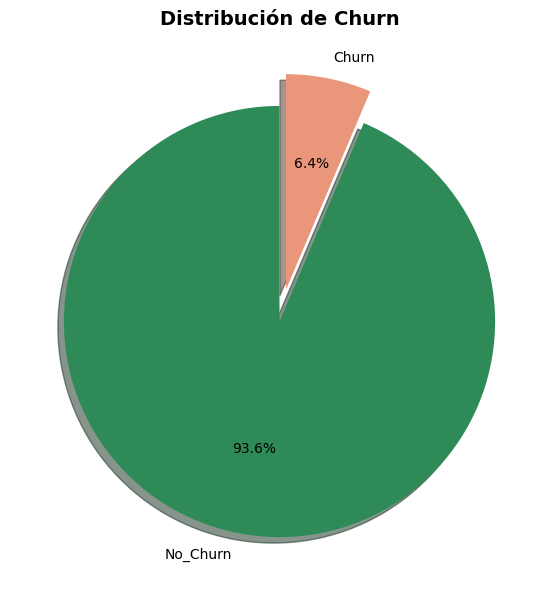

In [13]:
import matplotlib.pyplot as plt

churn_count = df['is_churn'].value_counts()

fig, ax = plt.subplots(figsize=(10,7))

ax.pie(churn_count,colors=['seagreen', 'darksalmon'], labels=['No_Churn', 'Churn'], startangle=90, autopct='%1.1f%%', explode = (0,0.15), shadow=True)
ax.set_title("Distribución de Churn", pad=20, fontweight='bold', fontsize=14)
plt.show()

Con esta visualizacion, puedo ver que tengo un dataset muy desequilibrado, tendre que recurrir a tecnicas, como SMOTE, para evitar problemas en el entrenamiento.

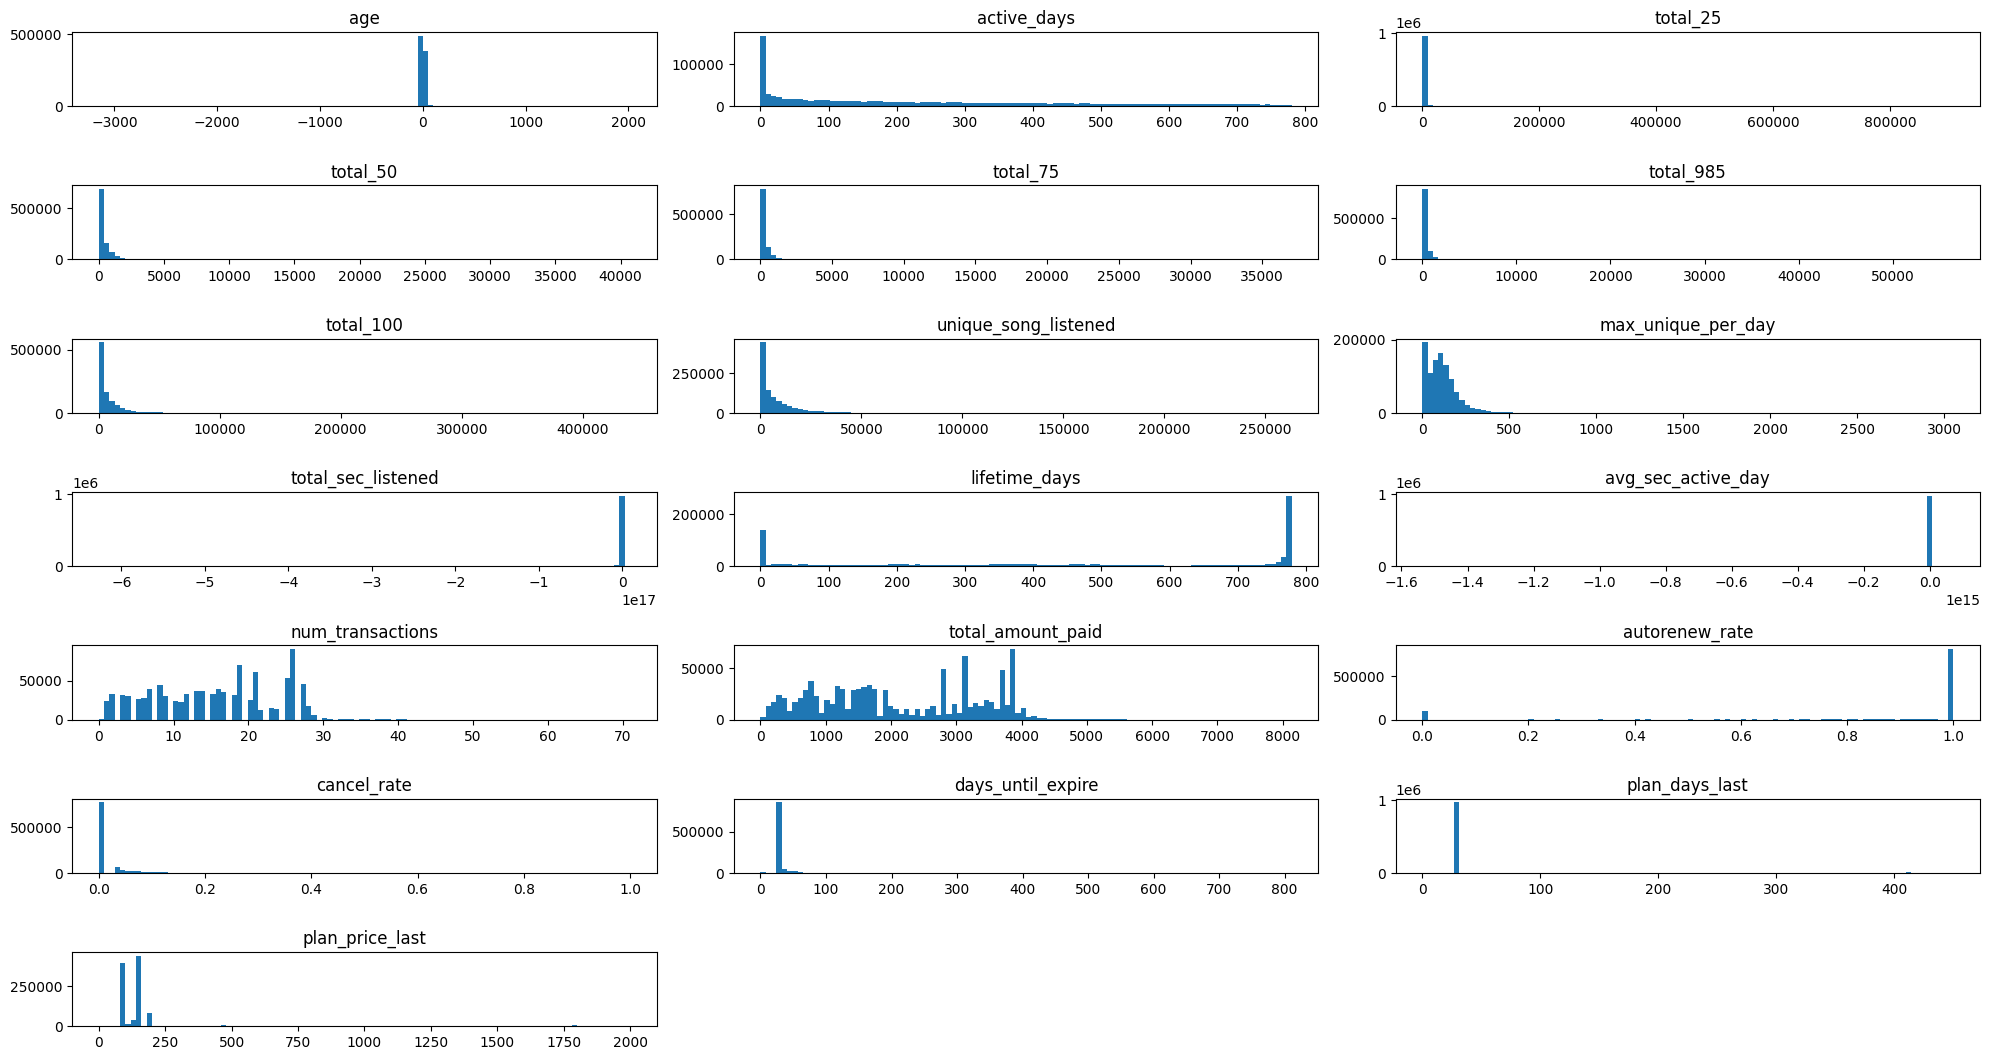

In [14]:
num_cols = df.select_dtypes(include=["number"]).columns.drop("is_churn")

n = len(df.columns)

fig, axes = plt.subplots(nrows=(n // 3) + (n % 3 > 0), ncols=3, figsize=(20, 12))
axes = axes.flatten()


for idx, var in enumerate(num_cols):
    axes[idx].hist(df[var],bins=100)
    axes[idx].set_title(var)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
    

In [16]:
pd.set_option("display.max_columns", None)
df.describe()   

,is_churn,age,registration_init_time,active_days,total_25,total_50,total_75,total_985,total_100,unique_song_listened,max_unique_per_day,total_sec_listened,first_activity,last_activity,lifetime_days,avg_sec_active_day,num_transactions,total_amount_paid,autorenew_rate,cancel_rate,days_until_expire,plan_days_last,plan_price_last
count,992931.000000,877161.000000,877161,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,9.929310e+05,869053,869053,992931.000000,9.929310e+05,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000,992931.000000
mean,0.063923,13.453973,2013-09-02 00:25:11.673227520,242.983514,1583.034782,393.295414,246.168141,273.287756,7444.498215,7320.508711,111.279809,-3.154552e+14,2015-09-07 09:29:56.008759296,2017-01-24 04:21:33.617765888,441.808805,-6.274643e+11,15.635531,2128.946648,0.875621,0.015312,35.896649,34.414835,147.638325
min,0.000000,-3152.000000,2004-03-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.271893e+17,2015-01-01 00:00:00,2015-01-01 00:00:00,0.000000,-1.537229e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2012-02-09 00:00:00,34.000000,114.000000,30.000000,19.000000,18.000000,402.000000,513.000000,48.000000,8.975629e+04,2015-01-02 00:00:00,2017-02-12 00:00:00,146.000000,2.341803e+03,8.000000,1089.000000,1.000000,0.000000,28.000000,30.000000,99.000000
50%,0.000000,0.000000,2014-05-14 00:00:00,180.000000,660.000000,180.000000,116.000000,118.000000,3233.000000,3560.000000,101.000000,8.194516e+05,2015-07-30 00:00:00,2017-02-18 00:00:00,460.000000,4.564603e+03,16.000000,1881.000000,1.000000,0.000000,28.000000,30.000000,149.000000
75%,0.000000,27.000000,2016-01-06 00:00:00,411.000000,1967.000000,514.000000,329.000000,344.000000,9704.000000,10146.000000,154.000000,2.490501e+06,2016-04-02 00:00:00,2017-02-18 00:00:00,774.000000,7.304172e+03,22.000000,3223.000000,1.000000,0.000000,31.000000,30.000000,149.000000
max,1.000000,2016.000000,2017-03-30 00:00:00,780.000000,908705.000000,40723.000000,37062.000000,56436.000000,439148.000000,263119.000000,3054.000000,9.223372e+15,2017-02-18 00:00:00,2017-02-18 00:00:00,779.000000,7.205759e+13,71.000000,8138.000000,1.000000,1.000000,811.000000,450.000000,2000.000000
std,0.244616,20.226865,NaN,227.101561,2790.002709,606.793448,369.659714,496.200996,12064.380158,10336.166346,93.609120,3.966760e+15,NaN,NaN,302.188905,8.195966e+12,8.234751,1229.230531,0.310046,0.039283,41.064401,35.611468,152.900231


In [ ]:
df